# Inventory Optimisation

In this notebook, we will explore a comprehensive approach to calculate the optimal stock order for each product in each month to optimisise our inventory. 

## Installing Relevant Packages

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

## Data Loading and Date Conversion and Mapping Profit Margins

We start off with loading the dataset and converting the year_month column to a datetime format to allow us to use date-based operations.Next, we map each product category to its gross profit margin using the information from the Industry Profit Margins data (FullRatio, 2024). Products with a higher margin will be prioritised for stock adjustments, ensuring more availability for profitable items.


In [125]:
data = pd.read_csv('../data/train_predictions.csv')
industry_profit_margins = pd.read_csv('../data/industry_profit_margins.csv')

industry_profit_margins['Average Gross Profit Margin'] = (
    industry_profit_margins['Average Gross Profit Margin'].str.replace('%', '').astype(float) / 100
)

category_to_industry_mapping = {
    'Accessories': 'Footwear & Accessories, Accessories & Luxury Goods',
    'Apparel': 'Apparel, Apparel Retail',
    'Bags': 'Apparel Retail',
    'Drinkware': 'Beverages - Non-Alcoholic',
    'Electronics': 'Consumer Electronics',
    'Fun': 'Toys & Games, Entertainment',
    'Gift Cards': 'Speciality Retail',
    'Headgear': 'Apparel Retail',
    'Housewares': 'Household Products',
    'Lifestyle': 'Personal Products',
    'Notebooks & Journals': 'Publishing',
    'Office': 'Office Supplies'
}

data['mapped_industry'] = data['product_category'].map(category_to_industry_mapping)
industry_profit_mapping = industry_profit_margins.set_index('Industry')['Average Gross Profit Margin'].to_dict()
data['gross_profit_margin'] = data['mapped_industry'].map(industry_profit_mapping)
default_margin = 0.2
data['gross_profit_margin'].fillna(default_margin, inplace=True)

C:\Users\Janis\AppData\Local\Temp\ipykernel_18908\4231288330.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['gross_profit_margin'].fillna(default_margin, inplace=True)


## Calculating Mean Demand and Assigning Dynamic Service Levels

We first calculate the average demand for each product category using the mean demand using a customised calculation. We then assign a service level based on the mean demand and map the calculated service levels back to the main data. Categories with higher-demand products will have a higher service level.

| CV Range     | Assigned Service Level |
|--------------|------------------------|
| CV < 1       | 90%                    |
| 1 ≤ CV < 2   | 93%                    |
| 2 ≤ CV < 3   | 95%                    |
| 3 ≤ CV < 4   | 97%                    |
| CV ≥ 4       | 98%                    |

In [126]:
category_demand_stats = data.groupby('product_category')['forecast_qty'].mean().reset_index()
category_demand_stats = category_demand_stats.rename(columns={'forecast_qty': 'mean_demand'})

def assign_service_level(mean_demand):
    if mean_demand < 1:
        return 0.90  # Low variability
    elif 1 <= mean_demand < 2:
        return 0.93  # Moderate variability
    elif 2 <= mean_demand < 3:
        return 0.95  # High variability
    elif 3 <= mean_demand < 4:
        return 0.97  # Very high variability
    else:
        return 0.98  # Extremely high variability

category_demand_stats['service_level'] = category_demand_stats['mean_demand'].apply(assign_service_level)
service_level_mapping = category_demand_stats.set_index('product_category')['service_level'].to_dict()
data['service_level'] = data['product_category'].map(service_level_mapping)

print(category_demand_stats[['product_category', 'mean_demand', 'service_level']])

        product_category  mean_demand  service_level
0            Accessories     3.159091           0.97
1                Apparel     0.631697           0.90
2                   Bags    15.622951           0.98
3              Drinkware    33.010536           0.98
4            Electronics    12.578431           0.98
5                    Fun     7.033333           0.98
6             Gift Cards     2.625000           0.95
7               Headgear     4.572785           0.98
8             Housewares    25.466667           0.98
9              Lifestyle    20.245556           0.98
10  Notebooks & Journals    27.920455           0.98
11                Office    41.282960           0.98


## Calculate Demand Variability for Individual Products and set Lead Time

We calculate standard deviation of demand for each product as demand_variability. The higher the service level, the higher the safety stock requirement, which reduces stockouts but increases holding costs.


In [127]:
data['demand_variability'] = data.groupby('product_id')['forecast_qty'].transform('std').fillna(0)
lead_time = 2

## Safety Stock Calculation

We proceed to calculate the mean demand for each product, and use Poisson distribution to calculate safety_stock_poisson, which adjusts safety stock based on service level and mean demand (Sortly, 2024).

In [128]:
data['mean_demand'] = data.groupby('product_id')['forecast_qty'].transform('mean')
data['safety_stock_poisson'] = data.apply(
    lambda row: poisson.ppf(row['service_level'], row['mean_demand']) - row['mean_demand'], axis=1
)

## Safety Stock Adjustment

This adjusts safety stock based on profit margin. Higher-margin items receive a proportionally higher safety stock buffer. The scaling factor 0.3 controls the strength of this adjustment.

In [129]:
profit_margin_scale = 0.3
data['adjusted_safety_stock'] = data['safety_stock_poisson'] * (1 + data['gross_profit_margin'] * profit_margin_scale)

## Seasonal Adjustment and Calculate Reorder Amount

According to seasonal factors for certain months with higher demands such as December, we include a customised seasonal buffer to ensure we have enough stock during peak sales periods (Jezy, 2024). Some examples include New Year's in January, back to school season in July / August, Black Friday and Cyber Monday sales in November, and the holiday season in December. We then determine the reorder amount based on forecasted demand and safety stock. This represents the quantity to meet demand.

In [130]:
data['year_month'] = pd.to_datetime(data['year_month'], errors='coerce')
data['month'] = data['year_month'].dt.month

seasonal_multipliers = {
    1: 1.1,
    2: 1.05,
    3: 1.0,
    4: 1.0,
    5: 1.05,
    6: 1.0,
    7: 1.15,
    8: 1.1,
    9: 1.0,
    10: 1.2,
    11: 1.25,
    12: 1.3
}

data['seasonal_adjustment'] = data['month'].map(seasonal_multipliers).fillna(1.0)
data['final_safety_stock'] = data['adjusted_safety_stock'] * data['seasonal_adjustment']

## Calculate Final Reorder Amount

By adding forecast quantity to the dinal safety stock, we calculate the reorder amount. Then, we include an additional 10% buffer for items with high demand variability to prevent stockouts for unpredictable items. We then round up the final reorder amount.

In [131]:
data['reorder_amount'] = data['forecast_qty'] + data['final_safety_stock']
high_variability_threshold = 10
variability_multiplier = 1.1
data['final_reorder_amount'] = np.where(
    data['demand_variability'] > high_variability_threshold,
    data['reorder_amount'] * variability_multiplier,
    data['reorder_amount']
)
data['final_reorder_amount'] = np.ceil(data['final_reorder_amount'])

## Group by Month and Product and Provide Final Output

We aggregate the reorder ampunts by month and product to provide a *monthly* reorder plan which shows how much stock to order each month for each product. We then output the first few rows of our monthly_reorder dataframe. We also output a graph which shows the reorder amount over a year for the user to better identify if there is a trend in the reorder amounts. This will be added on our frontend.

  year_month      product_id  final_reorder_amount
0 2016-08-01  GGOEA0CH077599                   8.0
1 2016-08-01  GGOEAAAB034813                   6.0
2 2016-08-01  GGOEAAAB034814                  14.0
3 2016-08-01  GGOEAAAB034815                  14.0
4 2016-08-01  GGOEAAAB034816                  13.0


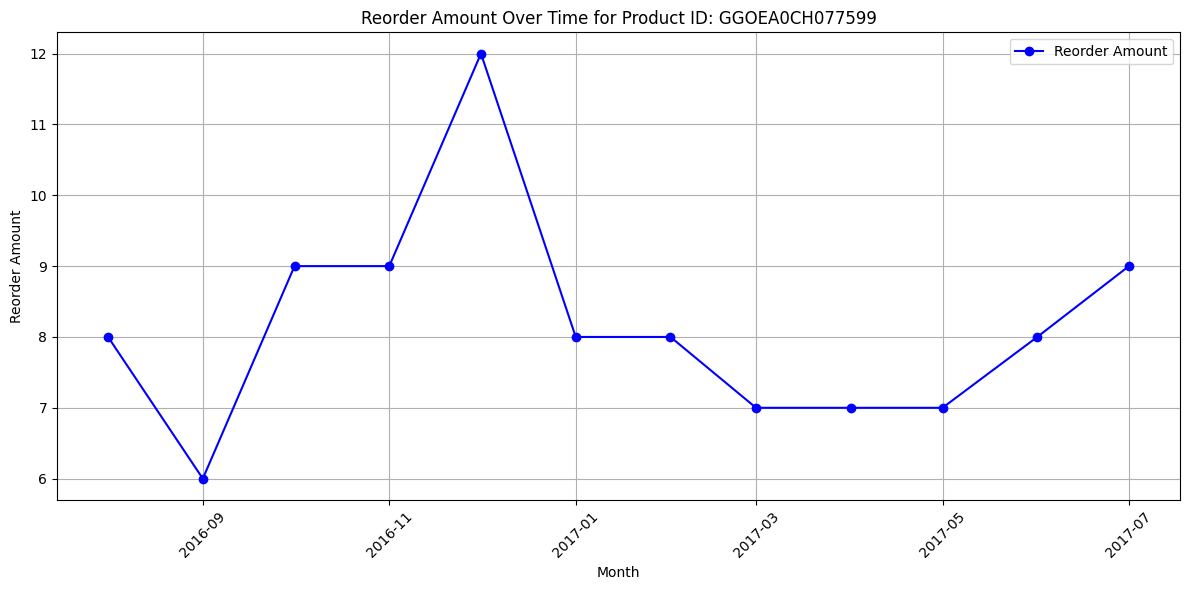

In [132]:
monthly_reorder = data.groupby([data['year_month'].dt.to_period('M'), 'product_id'])['final_reorder_amount'].sum().reset_index()
monthly_reorder['year_month'] = monthly_reorder['year_month'].dt.to_timestamp()
monthly_reorder.to_csv("../data/monthly_reorder.csv", index = False)

print(monthly_reorder.head())

sample_product_id = 'GGOEA0CH077599' # Replace with product id for viewing

sample_reorder_train = monthly_reorder[monthly_reorder['product_id'] == sample_product_id]

plt.figure(figsize=(12, 6))
plt.plot(sample_reorder_train['year_month'], sample_reorder_train['final_reorder_amount'], marker='o', color='b', label='Reorder Amount')
plt.title(f'Reorder Amount Over Time for Product ID: {sample_product_id}')
plt.xlabel('Month')
plt.ylabel('Reorder Amount')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


## Use test data for Next Month Predictions

We apply the same processing to test data.

In [123]:
test_data = pd.read_csv('../data/forecast_predictions.csv')
test_data['year_month'] = pd.to_datetime('2017-08-01')
test_data['service_level'] = test_data['product_category'].map(service_level_mapping)
test_data['gross_profit_margin'] = test_data['product_category'].map(category_to_industry_mapping).map(industry_profit_mapping).fillna(default_margin)

historical_demand_variability = data.groupby('product_id')['forecast_qty'].std()
test_data['demand_variability'] = test_data['product_id'].map(historical_demand_variability).fillna(0)
test_data['seasonal_adjustment'] = seasonal_multipliers.get(8, 1.0)

test_data['mean_demand'] = test_data.groupby('product_id')['forecast_qty'].transform('mean')
test_data['safety_stock_poisson'] = test_data.apply(
    lambda row: poisson.ppf(row['service_level'], row['mean_demand']) - row['mean_demand'], axis=1
)
test_data['adjusted_safety_stock'] = test_data['safety_stock_poisson'] * (1 + test_data['gross_profit_margin'] * profit_margin_scale)
test_data['final_safety_stock'] = test_data['adjusted_safety_stock'] * test_data['seasonal_adjustment']
test_data['reorder_amount'] = test_data['forecast_qty'] + test_data['final_safety_stock']
test_data['final_reorder_amount'] = np.where(
    test_data['demand_variability'] > high_variability_threshold,
    test_data['reorder_amount'] * variability_multiplier,
    test_data['reorder_amount']
)
test_data['final_reorder_amount'] = np.ceil(test_data['final_reorder_amount'])

monthly_reorder_test = test_data.groupby(['year_month', 'product_id'])['final_reorder_amount'].sum().reset_index()
print("\nNext Month's Reorder Plan (Test Data - August 2017):")
print(monthly_reorder_test.head())


Next Month's Reorder Plan (Test Data - August 2017):
  year_month      product_id  final_reorder_amount
0 2017-08-01  GGOEA0CH077599                   8.0
1 2017-08-01  GGOEAAAB034813                   9.0
2 2017-08-01  GGOEAAAB034814                  14.0
3 2017-08-01  GGOEAAAB034815                  19.0
4 2017-08-01  GGOEAAAB034816                  17.0


In [ ]:
monthly_reorder_test.to_csv('../data/monthly_reorder_test.csv', index = False)

# Citations

FullRatio. (2024) Profit margin by industry https://fullratio.com/profit-margin-by-industry

Jezy, M. (2024). Amazon Peak Season 2024: All about the most important peak season days in e-commerce. Quivo. https://quivo.co/us/amazon-peak-season-most-important-e-commerce-days-2024

Sortly. (Feb 2024) Calculating the Right Amount of Buffer Stock https://www.sortly.com/blog/buffer-stock/